In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
import pickle
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

In [2]:
df = pd.read_csv('prepared_dataset.csv', index_col = 0)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,0.801265,0.388479,1,1
1,0,61.0,0,0,1,3,0,0.679023,0.262925,2,1
2,1,80.0,0,1,1,2,0,0.234512,0.327917,2,1
3,0,49.0,0,0,1,2,1,0.536008,0.355982,3,1
4,0,79.0,1,0,1,3,0,0.549349,0.202363,2,1


### Разделяем датасет на тренировочную и тестовую выборку в отношении 80/20 соответсвенно

In [3]:
X = df[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status']]
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123,stratify=y)

### Проводим подбор гиперпараметров моделей и обучаем итоговый классификатор с лучшими параметрами

#### Рандомный лес

In [4]:
param_grid = { 
    'n_estimators': [50, 100, 215, 200],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
model = RandomForestClassifier(random_state=42)

CV_rfc = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5)

CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

{'criterion': 'gini', 'max_depth': 8, 'n_estimators': 50}

In [5]:
best_model_forest = RandomForestClassifier(random_state=42, n_estimators= 50, max_depth=8, criterion='gini')
best_model_forest.fit(X_train, y_train)

pred_train_forest = best_model_forest.predict(X_train)
pred_test_forest = best_model_forest.predict(X_test)
rf_accuracy_train = round(accuracy_score(y_train, pred_train_forest), 4)
rf_accuracy_test = round(accuracy_score(y_test, pred_test_forest), 4)

print(f"Accuracy for Train set Random Forest: {rf_accuracy_train}",
      f"Accuracy for Test set Random Forest: {rf_accuracy_test} ",
      sep='\n')

Accuracy for Train set Random Forest: 0.8996
Accuracy for Test set Random Forest: 0.9026 


#### Классификатор К-ближайших соседей

In [6]:
param_grid = { 
    'leaf_size': [1, 2, 3, 4, 5, 10, 15, 20],
    'n_neighbors' : [5, 15, 20, 25, 30, 40, 50],
    'weights' : ['uniform', 'distance'], 
    'p' : [1, 2]
}
model =  KNeighborsClassifier()

CV_rfc = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5)

CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

{'leaf_size': 1, 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}

In [7]:
best_model_knn = KNeighborsClassifier(leaf_size = 1, n_neighbors = 5, p = 1, weights = 'distance')
best_model_knn.fit(X_train, y_train)

pred_train_knn = best_model_knn.predict(X_train)
pred_test_knn = best_model_knn.predict(X_test)
knn_accuracy_train = round(accuracy_score(y_train, pred_train_knn), 4)
knn_accuracy_test = round(accuracy_score(y_test, pred_test_knn), 4)

print(f"Accuracy for Train set KNN: {knn_accuracy_train}",
      f"Accuracy for Test set KNN: {knn_accuracy_test} ",
      sep='\n')

Accuracy for Train set KNN: 1.0
Accuracy for Test set KNN: 0.953 


#### Логистическая регрессия

In [8]:
param_grid = { 
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
}
model =  LogisticRegression()

CV_rfc = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5)

CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

{'penalty': None, 'solver': 'newton-cholesky'}

In [9]:
best_model_log = LogisticRegression(random_state = 42, solver='newton-cholesky', penalty = None)
best_model_log.fit(X_train, y_train)

pred_train_log = best_model_log.predict(X_train)
pred_test_log = best_model_log.predict(X_test)
accuracy_lr_train = round(accuracy_score(y_train, pred_train_log), 4)
accuracy_lr_test = round(accuracy_score(y_test, pred_test_log), 4)

print(f"Accuracy for Train set KNN: {accuracy_lr_train}",
      f"Accuracy for Test set KNN: {accuracy_lr_test} ",
      sep='\n')

Accuracy for Train set KNN: 0.7723
Accuracy for Test set KNN: 0.7804 


#### Ансамбль моделей классификации

In [10]:
estimators = [('lg', best_model_log),
              ('knn', best_model_knn), 
              ('tree', best_model_forest)]
final_estimator = LogisticRegression()
FinalStack = VotingClassifier(estimators = estimators, voting = 'soft', weights = [1, 3, 1])
FinalStack.fit(X_train, y_train)

FinalStack_train = FinalStack.predict(X_train)
FinalStack_accuracy_train = accuracy_score(y_train, FinalStack_train)

FinalStack_y_pred_test = FinalStack.predict(X_test)
FinalStack_accuracy_test = accuracy_score(y_test, FinalStack_y_pred_test)

print(f"Accuracy for Train set FinalStack: {FinalStack_accuracy_train}",
      f"Accuracy for Test set FinalStack: {FinalStack_accuracy_test} ",
      sep='\n')

Accuracy for Train set FinalStack: 1.0
Accuracy for Test set FinalStack: 0.9480712166172107 


In [11]:
models = [('Logistic Regression', accuracy_lr_train, accuracy_lr_test),
          ('K-Nearest Neighbors', knn_accuracy_train, knn_accuracy_test),
          ('Random Forest Tree', rf_accuracy_train, rf_accuracy_test),
          ('Voting Classifier', FinalStack_accuracy_train, FinalStack_accuracy_test)]

predict = pd.DataFrame(data = models, columns=['Model',  'Accuracy(training)', 'Accuracy(test)'])
predict = predict.sort_values(by = 'Accuracy(test)')

#### Проводим сравнение моделей

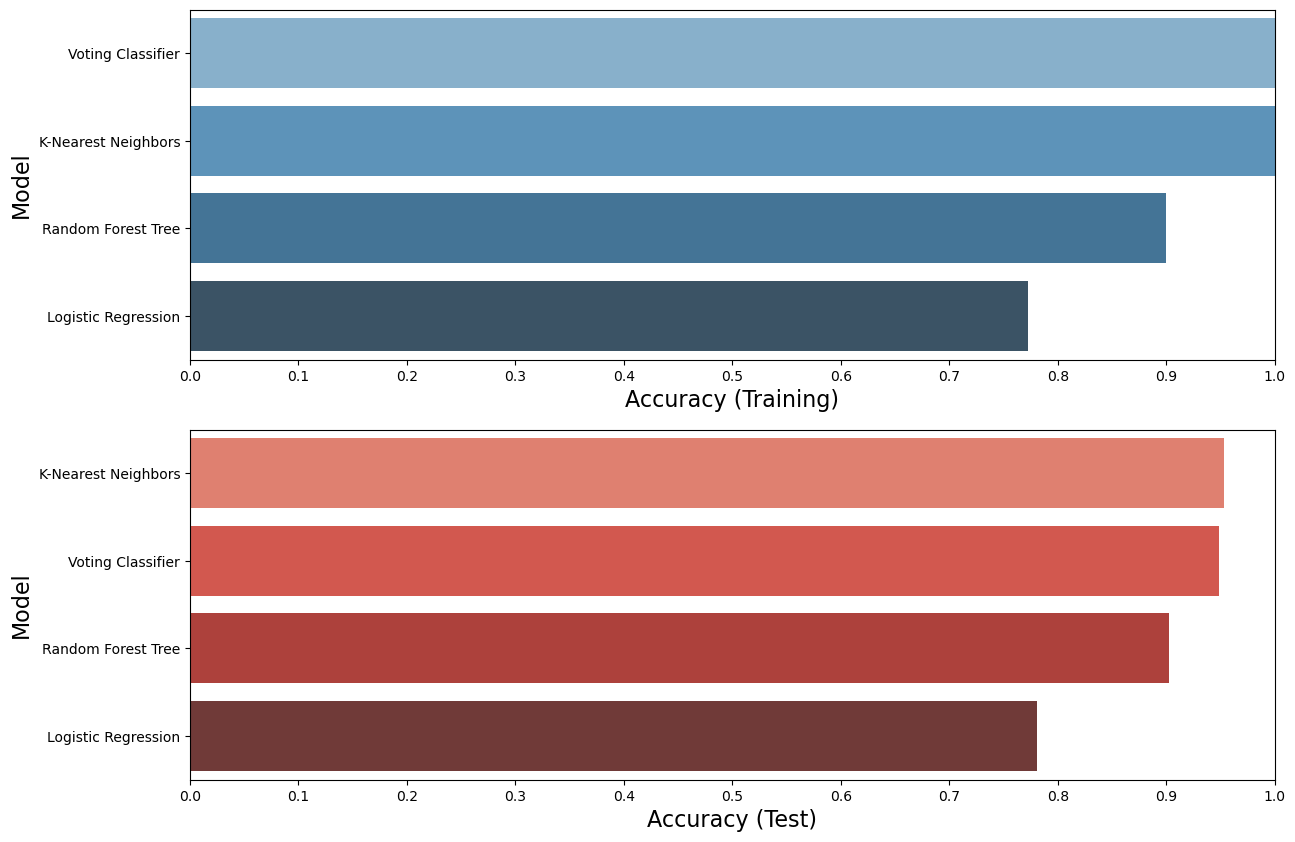

In [12]:
f, axes = plt.subplots(2,1, figsize=(14,10))
predict.sort_values(by = ['Accuracy(training)'], ascending = False, inplace = True)
sns.barplot(x = 'Accuracy(training)', y = 'Model', data = predict, palette='Blues_d', ax = axes[0])
axes[0].set_xlabel('Accuracy (Training)', size=16)
axes[0].set_ylabel('Model', size=16)
axes[0].set_xlim(0,1.0)
axes[0].set_xticks(np.arange(0, 1.1, 0.1))
predict.sort_values(by=['Accuracy(test)'], ascending = False, inplace = True)
sns.barplot(x = 'Accuracy(test)', y = 'Model', data = predict, palette = 'Reds_d', ax = axes[1])
axes[1].set_xlabel('Accuracy (Test)', size=16)
axes[1].set_ylabel('Model', size=16)
axes[1].set_xlim(0,1.0)
axes[1].set_xticks(np.arange(0, 1.1, 0.1))
plt.show()

Лучшая модель - К-ближайших соседей, ее мы и будем использовать для совершения предсказаний в нашем сервисе. Сохраним ее для дальнейших исследований.

In [13]:
pkl_filename = "prediction_model.pkl" 
with open(pkl_filename, 'wb') as file: 
     pickle.dump(best_model_knn, file)